In [18]:
import pymc

import hddm

In [19]:
import hddm
import bauer
import numpy as np

In [20]:
from bauer.utils.data import load_garcia2022

In [21]:
df = load_garcia2022()
df['response'] = (df['choice']).astype(np.float)
df['subj_idx'] = df.index.get_level_values('subject')

df['rt'] = df['rt'] / 1000.


df['log(n2/n1)'] = np.log(df['n2'] / df['n1'])

df['log_n1'] = np.log(df['n1'])
df['log_n2'] = np.log(df['n2'])

/tmp/ipykernel_601/2964034845.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['response'] = (df['choice']).astype(np.float)


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt


# sns.relplot(x='log_n1', y='choice', data=df.reset_index(), kind='line')
# sns.relplot(x='log(n2/n1)', y='response', data=df.reset_index(), kind='line')
# plt.axvline(0.0, c='k', ls='--')

<AxesSubplot: xlabel='rt', ylabel='Density'>

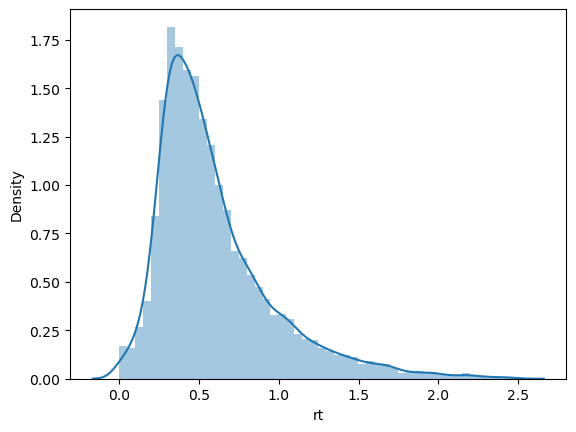

In [23]:
sns.distplot(df['rt'])

In [24]:
df.loc[~df.choice, 'rt'] *= -1.

<AxesSubplot: xlabel='rt', ylabel='Density'>

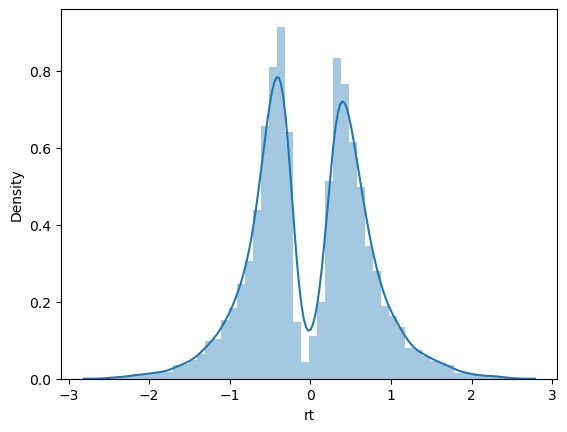

In [25]:
sns.distplot(df['rt'])

In [26]:
data = df.reset_index(drop=True)

model = hddm.HDDMRegressor(data.reset_index(), models=['v ~ 1 + log_n1 + log_n2'], 
                           include=['v', 'a', 't', 'sv'],
                           p_outlier=0.05,
                           group_only_regressors=False,
                           is_group_model=True,
                           )

idata = model.sample(200, burn=100, return_infdata = True, ppc=True, loglike=True)

No model attribute --> setting up standard HDDM
Set model to full_ddm
 [-----------------100%-----------------] 201 of 200 complete in 175.3 sechddm sampling elpased time:  175.505 s
Start to calculate pointwise log likelihood...
The time of calculation of loglikelihood took 93.660 seconds
Start generating posterior prediction...
The time of generating PPC took 77.851 seconds
Start converting to InferenceData...


<AxesSubplot: xlabel='v_Intercept', ylabel='Density'>

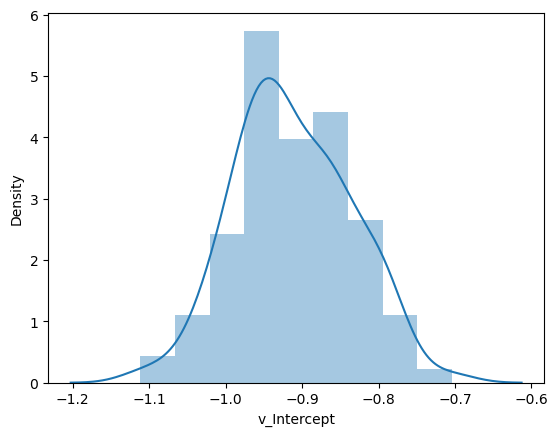

In [27]:
sns.distplot(idata.posterior['v_Intercept'])

<AxesSubplot: xlabel='v_log_n2', ylabel='Density'>

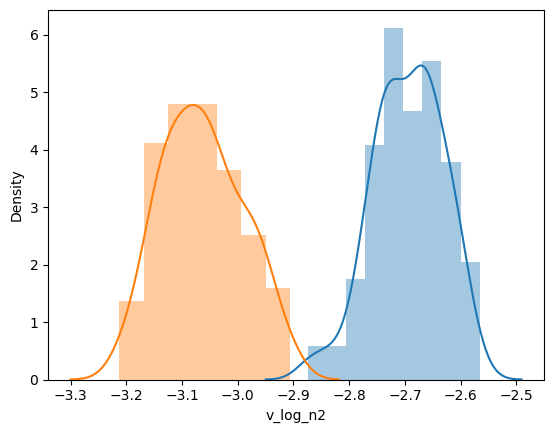

In [28]:
sns.distplot(idata.posterior['v_log_n1'])
sns.distplot(-idata.posterior['v_log_n2'])

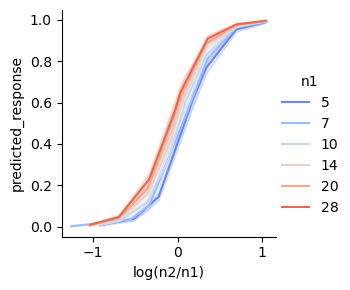

In [29]:
import pandas as pd


tmp = idata.posterior_predictive['response'].to_dataframe()['response'].unstack('obs_id')

tmp.columns = pd.MultiIndex.from_frame(data[['n1', 'n2', 'log(n2/n1)', 'subj_idx']])

x = tmp.T.mean(1).to_frame('predicted_response')


# sns.relplot(x='log(n2/n1)', y='predicted_response', hue='n1', data=x.reset_index(), kind='line')
x['real_response'] = df['choice'].values

g = sns.FacetGrid(x.groupby(['subj_idx', 'log(n2/n1)', 'n1']).mean().reset_index(),hue='n1', palette='coolwarm')

g.map_dataframe(sns.lineplot, x='log(n2/n1)', y='predicted_response', )
# g.map_dataframe(sns.scatterplot, x='log(n2/n1)', y='real_response')

g.add_legend()

In [37]:
from arviz import hdi


def get_hdi(d):
    return pd.Series(hdi(d.values[np.newaxis, :])[0], index=['hdi025', 'hdi975'])

In [38]:
tmp = idata.posterior_predictive['response'].to_dataframe()['response'].unstack('obs_id').T
tmp.index = pd.MultiIndex.from_frame(data[['n1', 'n2', 'log(n2/n1)', 'subj_idx']])
tmp = tmp.stack()

stats = tmp.groupby(['draw', 'n1', 'subj_idx']).mean().groupby(['n1' ]).mean().rename(columns={0:'mean'})
ci = tmp.groupby(['draw', 'n1']).mean().groupby(['n1']).apply(get_hdi)

stats = stats.join(ci)
stats = stats.join(df.groupby('n1')[['choice']].mean())

In [39]:
def plot_prediction(data, x, color, y='mean', alpha=.25, **kwargs):
    data = data[~data['hdi025'].isnull()]

    plt.fill_between(data[x], data['hdi025'],
                     data['hdi975'], color=color, alpha=alpha)
    return plt.plot(data[x], data[y], color=color)

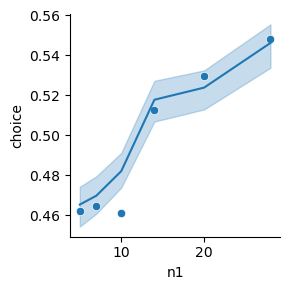

In [40]:
g = sns.FacetGrid(stats.reset_index(), palette=['k'])

g.map_dataframe(plot_prediction, x='n1')
g.map_dataframe(sns.scatterplot, x='n1', y='choice')

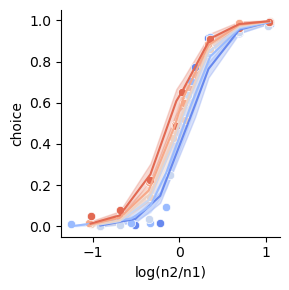

In [295]:
tmp = idata.posterior_predictive['response'].to_dataframe()['response'].unstack('obs_id').T
tmp.index = pd.MultiIndex.from_frame(data[['n1', 'n2', 'log(n2/n1)', 'subj_idx']])
tmp = tmp.stack()

stats = tmp.groupby(['draw', 'n1', 'log(n2/n1)', 'subj_idx']).mean().groupby(['n1', 'log(n2/n1)']).mean().rename(columns={0:'mean'})
ci = tmp.groupby(['draw', 'n1', 'log(n2/n1)']).mean().groupby(['n1', 'log(n2/n1)']).apply(get_hdi)

stats = stats.join(ci)
stats = stats.join(df.groupby(['n1', 'log(n2/n1)'])[['choice']].mean())

g = sns.FacetGrid(stats.reset_index(), palette='coolwarm', hue='n1')

g.map_dataframe(plot_prediction, x='log(n2/n1)')
g.map_dataframe(sns.scatterplot, x='log(n2/n1)', y='choice')

In [44]:
tmp = np.abs(idata.posterior_predictive['rt'].to_dataframe()['rt']).unstack('obs_id').T
tmp.index = pd.MultiIndex.from_frame(data[['n1', 'n2', 'log(n2/n1)', 'subj_idx']])
tmp = tmp.stack()

stats = tmp.groupby(['draw', 'n1', 'log(n2/n1)', 'subj_idx']).mean().groupby(['n1', 'log(n2/n1)']).mean().rename(columns={0:'mean'})
ci = tmp.groupby(['draw', 'n1', 'log(n2/n1)']).mean().groupby(['n1', 'log(n2/n1)']).apply(get_hdi)

stats = stats.join(ci)

df['rt_abs'] = df['rt'].abs()
stats = stats.join(df.groupby(['n1', 'log(n2/n1)'])[['rt_abs']].mean())

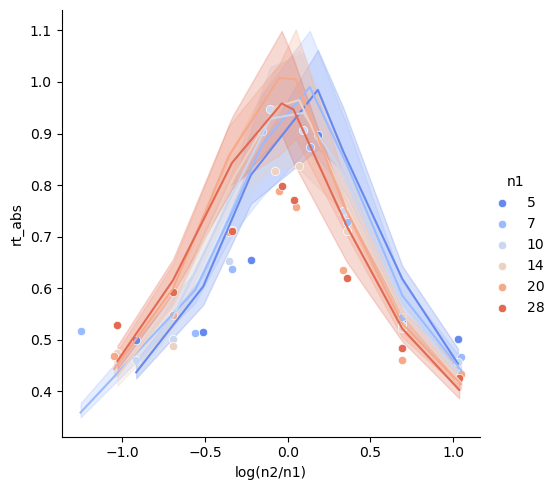

In [49]:
g = sns.FacetGrid(stats.reset_index(), palette='coolwarm', hue='n1', height=5.)

g.map_dataframe(plot_prediction, x='log(n2/n1)')
g.map_dataframe(sns.scatterplot, x='log(n2/n1)', y='rt_abs')
g.add_legend()

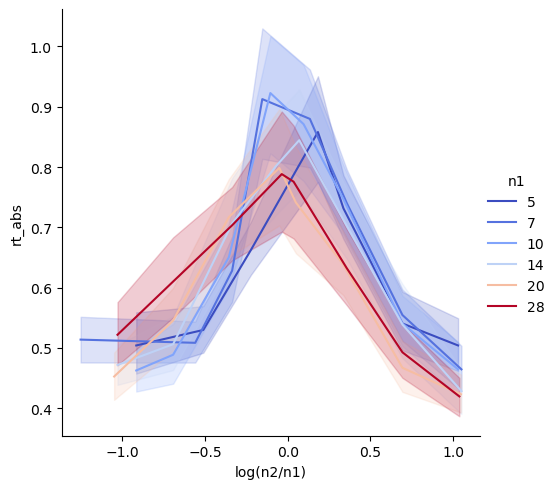

In [47]:
sns.relplot(x='log(n2/n1)', y='rt_abs', data=df.groupby(['subject', 'log(n2/n1)', 'n1']).mean().reset_index(), hue='n1', kind='line', palette='coolwarm')

# Starting point as well?

In [52]:
def link_function(x):
    return 1 / (1 + np.exp(-x))

data['z_n1'] = (data['n1'] - data['n1'].mean()) / data['n1'].std()

model = hddm.HDDMRegressor(data.reset_index(), models=['v ~ 1 + log_n1 + log_n2',
                                                       {'model': 'z ~ z_n1', 'link_func': link_function}], 
                           include=['v', 'a', 't', 'sv', 'z'],
                           p_outlier=0.05,
                           group_only_regressors=False,
                           is_group_model=True,
                           )

idata = model.sample(200, burn=100, return_infdata = True, ppc=True, loglike=True)

No model attribute --> setting up standard HDDM
Set model to full_ddm
 [-----------------100%-----------------] 201 of 200 complete in 399.7 sechddm sampling elpased time:  400.278 s
Start to calculate pointwise log likelihood...
The time of calculation of loglikelihood took 142.512 seconds
Start generating posterior prediction...
The time of generating PPC took 117.524 seconds
Start converting to InferenceData...


<AxesSubplot: ylabel='Density'>

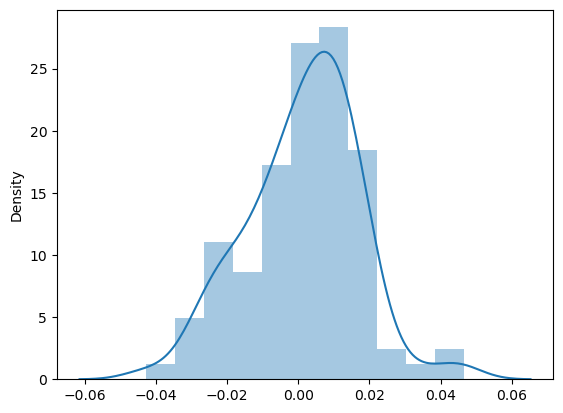

In [58]:
sns.distplot(idata.posterior[['z_z_n1']].to_dataframe())

<AxesSubplot: ylabel='Density'>

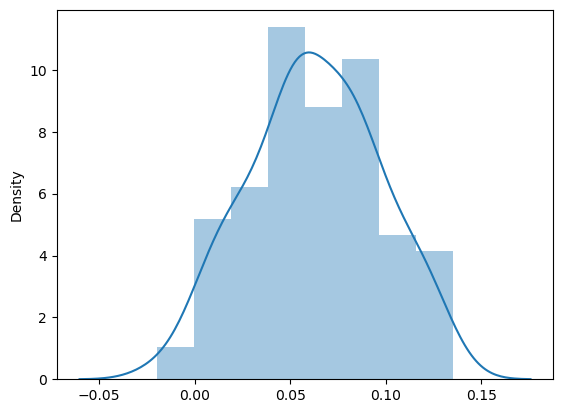

In [59]:
sns.distplot(idata.posterior[['z_Intercept']].to_dataframe())

<AxesSubplot: xlabel='v_Intercept', ylabel='Density'>

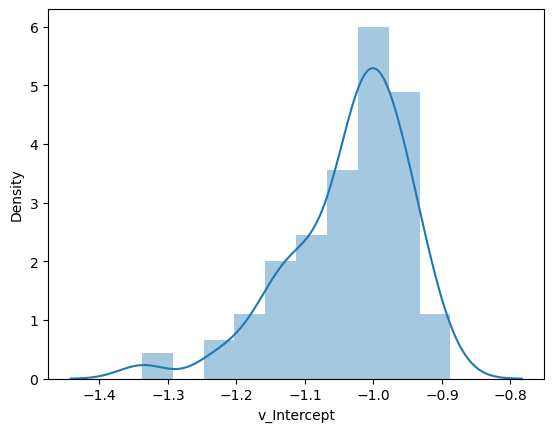

In [63]:
sns.distplot(idata.posterior['v_Intercept'])

<AxesSubplot: xlabel='v_log_n2', ylabel='Density'>

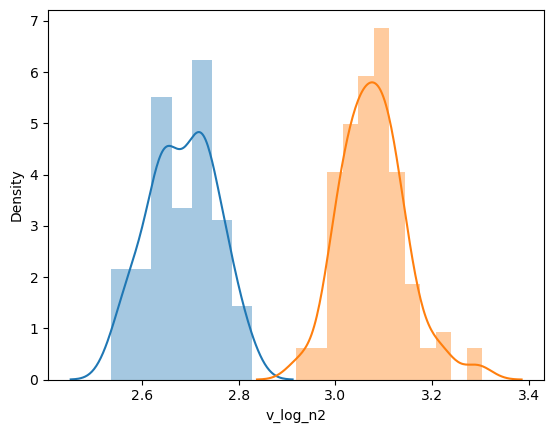

In [65]:
sns.distplot(-idata.posterior['v_log_n1'])
sns.distplot(idata.posterior['v_log_n2'])

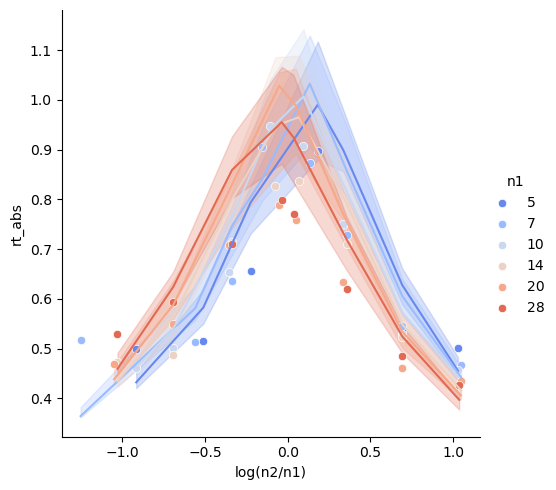

In [54]:
tmp = np.abs(idata.posterior_predictive['rt'].to_dataframe()['rt']).unstack('obs_id').T
tmp.index = pd.MultiIndex.from_frame(data[['n1', 'n2', 'log(n2/n1)', 'subj_idx']])
tmp = tmp.stack()

stats = tmp.groupby(['draw', 'n1', 'log(n2/n1)', 'subj_idx']).mean().groupby(['n1', 'log(n2/n1)']).mean().rename(columns={0:'mean'})
ci = tmp.groupby(['draw', 'n1', 'log(n2/n1)']).mean().groupby(['n1', 'log(n2/n1)']).apply(get_hdi)

stats = stats.join(ci)

df['rt_abs'] = df['rt'].abs()
stats = stats.join(df.groupby(['n1', 'log(n2/n1)'])[['rt_abs']].mean())

g = sns.FacetGrid(stats.reset_index(), palette='coolwarm', hue='n1', height=5.)

g.map_dataframe(plot_prediction, x='log(n2/n1)')
g.map_dataframe(sns.scatterplot, x='log(n2/n1)', y='rt_abs')
g.add_legend()

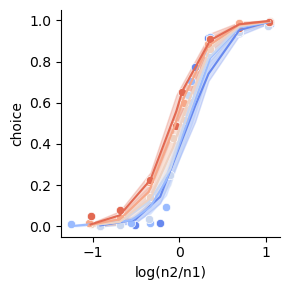

In [66]:
tmp = idata.posterior_predictive['response'].to_dataframe()['response'].unstack('obs_id').T
tmp.index = pd.MultiIndex.from_frame(data[['n1', 'n2', 'log(n2/n1)', 'subj_idx']])
tmp = tmp.stack()

stats = tmp.groupby(['draw', 'n1', 'log(n2/n1)', 'subj_idx']).mean().groupby(['n1', 'log(n2/n1)']).mean().rename(columns={0:'mean'})
ci = tmp.groupby(['draw', 'n1', 'log(n2/n1)']).mean().groupby(['n1', 'log(n2/n1)']).apply(get_hdi)

stats = stats.join(ci)
stats = stats.join(df.groupby(['n1', 'log(n2/n1)'])[['choice']].mean())

g = sns.FacetGrid(stats.reset_index(), palette='coolwarm', hue='n1')

g.map_dataframe(plot_prediction, x='log(n2/n1)')
g.map_dataframe(sns.scatterplot, x='log(n2/n1)', y='choice')

# Model without scalar invariance

In [67]:
model = hddm.HDDMRegressor(data.reset_index(), models=['v ~ 1 + n1 + n2'],
                           include=['v', 'a', 't', 'sv'],
                           p_outlier=0.05,
                           group_only_regressors=False,
                           is_group_model=True,
                           )

idata = model.sample(200, burn=100, return_infdata = True, ppc=True, loglike=True)

No model attribute --> setting up standard HDDM
Set model to full_ddm
 [-----------------100%-----------------] 201 of 200 complete in 152.2 sechddm sampling elpased time:  152.366 s
Start to calculate pointwise log likelihood...
The time of calculation of loglikelihood took 104.025 seconds
Start generating posterior prediction...
The time of generating PPC took 68.702 seconds
Start converting to InferenceData...


<AxesSubplot: xlabel='v_Intercept', ylabel='Density'>

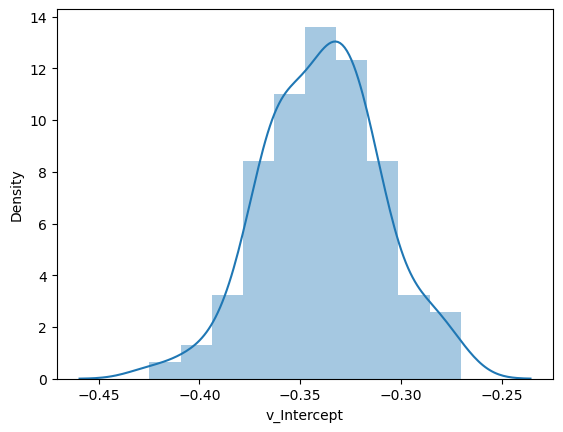

In [68]:
sns.distplot(idata.posterior['v_Intercept'])

<AxesSubplot: xlabel='v_n2', ylabel='Density'>

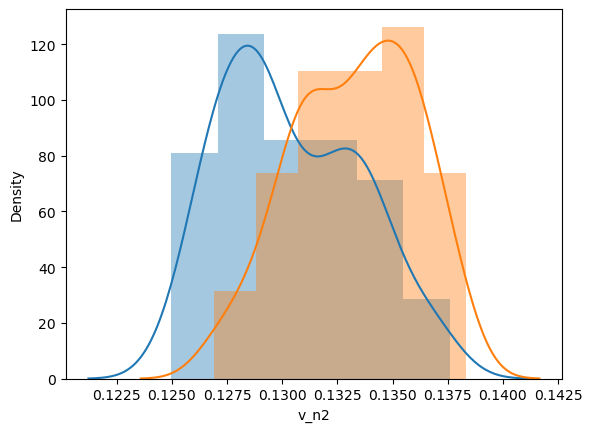

In [70]:
sns.distplot(-idata.posterior['v_n1'])
sns.distplot(idata.posterior['v_n2'])

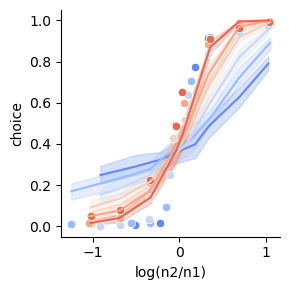

In [71]:
tmp = idata.posterior_predictive['response'].to_dataframe()['response'].unstack('obs_id').T
tmp.index = pd.MultiIndex.from_frame(data[['n1', 'n2', 'log(n2/n1)', 'subj_idx']])
tmp = tmp.stack()

stats = tmp.groupby(['draw', 'n1', 'log(n2/n1)', 'subj_idx']).mean().groupby(['n1', 'log(n2/n1)']).mean().rename(columns={0:'mean'})
ci = tmp.groupby(['draw', 'n1', 'log(n2/n1)']).mean().groupby(['n1', 'log(n2/n1)']).apply(get_hdi)

stats = stats.join(ci)
stats = stats.join(df.groupby(['n1', 'log(n2/n1)'])[['choice']].mean())

g = sns.FacetGrid(stats.reset_index(), palette='coolwarm', hue='n1')

g.map_dataframe(plot_prediction, x='log(n2/n1)')
g.map_dataframe(sns.scatterplot, x='log(n2/n1)', y='choice')

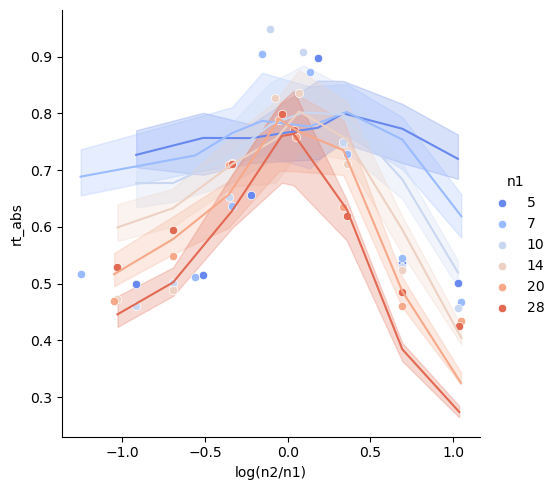

In [72]:
tmp = np.abs(idata.posterior_predictive['rt'].to_dataframe()['rt']).unstack('obs_id').T
tmp.index = pd.MultiIndex.from_frame(data[['n1', 'n2', 'log(n2/n1)', 'subj_idx']])
tmp = tmp.stack()

stats = tmp.groupby(['draw', 'n1', 'log(n2/n1)', 'subj_idx']).mean().groupby(['n1', 'log(n2/n1)']).mean().rename(columns={0:'mean'})
ci = tmp.groupby(['draw', 'n1', 'log(n2/n1)']).mean().groupby(['n1', 'log(n2/n1)']).apply(get_hdi)

stats = stats.join(ci)

df['rt_abs'] = df['rt'].abs()
stats = stats.join(df.groupby(['n1', 'log(n2/n1)'])[['rt_abs']].mean())

g = sns.FacetGrid(stats.reset_index(), palette='coolwarm', hue='n1', height=5.)

g.map_dataframe(plot_prediction, x='log(n2/n1)')
g.map_dataframe(sns.scatterplot, x='log(n2/n1)', y='rt_abs')
g.add_legend()